# Dictionary keys are:

- `id`: integer, id #
- `image_id`: integer, image id #
- `category_id`: 1 for penguin, 2 for turtle
- `bbox`: list of integers representing the bounding box coordinates in Pascal VOC format [xmin, ymin, xmax, ymax]
- `area`: integer representing area of bounding box.
- `segmentation`: empty list; add segmentation masks if you'd like!
- `iscrowd`: integer 0 or 1; whether the instance is a crowd or individual. Not relevant to this particular use case, but is a necessary key for some models.

In [ ]:
# Transform COCO annotations to YOLO format

import os
import json

def convert(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (box[0] + box[2] / 2.0) * dw
    y = (box[1] + box[3] / 2.0) * dh
    w = box[2] * dw
    h = box[3] * dh
    return [x, y, w, h]


def convert_annotation(image_info, output_path):
    image_id = str(image_info["image_id"]).zfill(3)
    with open(os.path.join(output_path, f"image_id_{image_id}.txt"), "w") as outfile:
        box = convert((640, 640), image_info["bbox"])
        outfile.write(
            f"{image_info['category_id']-1} {' '.join([str(a) for a in box])}\n"
        )


def coco_to_yolo(coco_annotation_file, output_path):
    os.makedirs(output_path, exist_ok=True)
    with open(coco_annotation_file) as file:
        data = json.load(file)
        for img in data:
            convert_annotation(img, output_path)


coco_to_yolo("datasets/train_annotations.json", "datasets/labels/train/")
coco_to_yolo("datasets/valid_annotations.json", "datasets/labels/valid/")

In [ ]:
# Date Preprocessing
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocessing(input_path: str, output_path: str):
    
    for file_name in os.listdir(input_path):
        original_img = cv2.imread(os.path.join(input_path, file_name))
        
        img = original_img.astype(np.float32)
        
        # Data Augmentation: Adding Gaussian Noise
        img += np.random.normal(0, 20, img.shape)
        
        # save image
        img = np.clip(img, 0, 255).astype(np.uint8)
        cv2.imwrite(os.path.join(output_path, file_name), img)
        
        
        # flip image
        img = cv2.flip(img, 1)
        name = file_name.split(".")[0] + "_flip.jpg"
        cv2.imwrite(os.path.join(output_path, name), img)
        
        # modify label
        name = file_name.split(".")[0] + "_flip.txt"
        with open(os.path.join("datasets/labels/train_preprocessed", name), "w") as f:
            with open(os.path.join("datasets/labels/train", file_name.split(".")[0] + ".txt"), "r") as f2:
                for line in f2:
                    line = line.split(" ")
                    line[1] = str(1 - float(line[1]))
                    f.write(" ".join(line))
        
        
        # # show changed image and the original image
        # cv2.imshow("original", original_img)
        # cv2.imshow("changed", img)
        
        # if cv2.waitKey(0) == ord('q'):
        #     cv2.destroyAllWindows()
        #     break



preprocessing("datasets/images/train", "datasets/images/train_preprocessed")

In [5]:
import torch
torch.cuda.is_available()

True

In [ ]:
# Training YOLOv8n on animal dataset

from ultralytics import YOLO

model = YOLO("datasets/weights/yolov8n.pt")

model.train(data="animal.yaml", imgsz=640, epochs=100, batch=8, workers=4, device=0)

In [ ]:
# Predicts on all images in datasets/images/valid

import os
import cv2

from ultralytics import YOLO

model = YOLO("runs/detect/train3/weights/best.pt")

for file in os.listdir("datasets/images/valid"):
    model.predict(
        os.path.join("datasets/images/valid", file),
        conf=0.8,
        save=True,
        save_conf=True,
        augment=True,
        # visualize=True,
        device=0,
    )


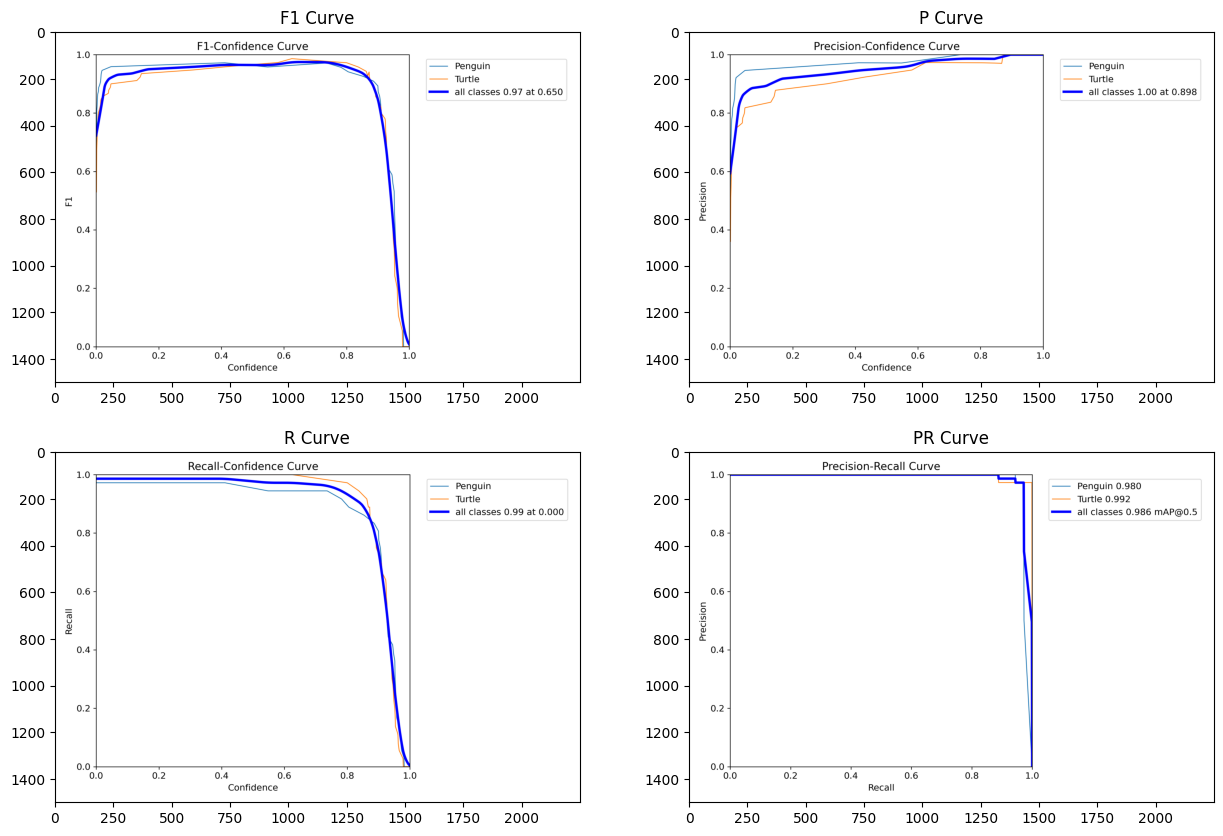

In [4]:
import cv2
import matplotlib.pyplot as plt

path = "runs/detect/train3"

img1 = "F1_curve.png"
img2 = "P_curve.png"
img3 = "R_curve.png"
img4 = "PR_curve.png"

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

img1 = cv2.imread(f"{path}/{img1}")
img2 = cv2.imread(f"{path}/{img2}")
img3 = cv2.imread(f"{path}/{img3}")
img4 = cv2.imread(f"{path}/{img4}")

axs[0, 0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('F1 Curve')

axs[0, 1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('P Curve')

axs[1, 0].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
axs[1, 0].set_title('R Curve')

axs[1, 1].imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('PR Curve')

plt.show()

# save image
fig.savefig(f"{path}/curves.png")
